# Project Title: Predictive Analysis for Employee Retention at Salifort Motors

### Business scenario and problem

#### Project Description:

Salifort Motors has recognized the importance of enhancing employee satisfaction and reducing attrition rates to maintain a thriving workplace environment. As a seasoned data analytics professional, I've been engaged by the HR department to leverage data-driven insights to address this critical challenge.

#### Business Scenario:

Salifort Motors, a prominent player in the automotive industry, acknowledges the significance of retaining its valued workforce. The HR department has taken proactive steps by collecting a rich dataset from employees. However, they face a fundamental question: What factors influence an employee's decision to leave the company?

## Step 1. Imports

### Import packages

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
from scipy import stats

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

### Load dataset

In [2]:
df0 = pd.read_csv("HR_capstone_dataset.csv")

df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (Initial EDA and data cleaning)

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Renaming columns

In [5]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
df0 = df0.rename(columns={"satisfaction_level": "satisfaction",
                    "number_project": "projects",
                    "average_montly_hours": "average_monthly_hours",
                    "time_spend_company": "tenure",
                    "Work_accident": "accident",
                    "promotion_last_5years": "promotion_5years",
                    "Department": "department"
                   })

df0.columns

Index(['satisfaction', 'last_evaluation', 'projects', 'average_monthly_hours',
       'tenure', 'accident', 'left', 'promotion_5years', 'department',
       'salary'],
      dtype='object')

### Checking for missing values

In [7]:
df0.isna().sum()

satisfaction             0
last_evaluation          0
projects                 0
average_monthly_hours    0
tenure                   0
accident                 0
left                     0
promotion_5years         0
department               0
salary                   0
dtype: int64

### Checking for duplicates

In [8]:
df0.duplicated().sum()

3008

In [9]:
df0[df0.duplicated()].head()

,satisfaction,last_evaluation,projects,average_monthly_hours,tenure,accident,left,promotion_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
df1 = df0.drop_duplicates(keep='first')

df1.head()

,satisfaction,last_evaluation,projects,average_monthly_hours,tenure,accident,left,promotion_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Checking for outliers

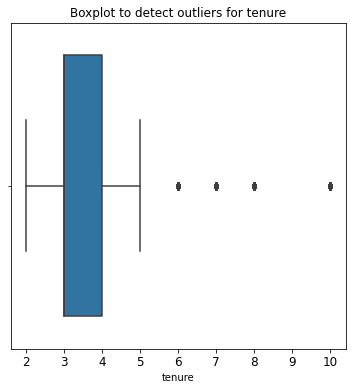

In [11]:
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [12]:
# 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)

# 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)

# Interquartile range in `tenure`
iqr = percentile75 - percentile25

# Upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Subset of data containing outliers in `tenure`
outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]

print("Number of rows in the data containing outliers in `tenure`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `tenure`: 824


## Step 2. Data Exploration (Continue EDA)

In [13]:
# left vs. stayed
df1["left"].value_counts()

# Percentages of people who left vs. stayed
df1["left"].value_counts(normalize=True)

0    0.833959
1    0.166041
Name: left, dtype: float64

### Data visualizations

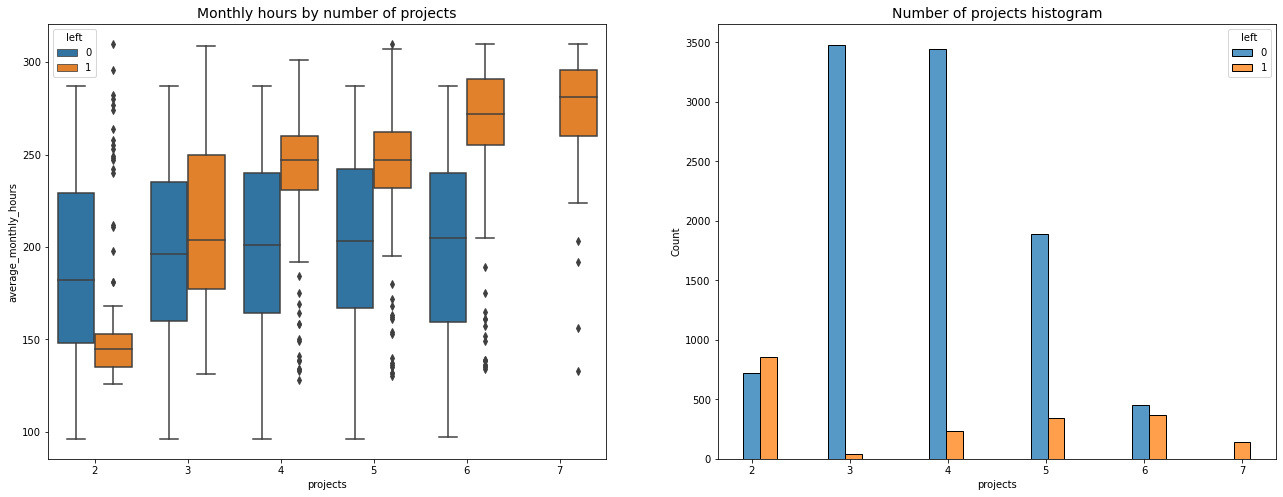

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

# Boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='projects', y='average_monthly_hours', hue='left', ax=ax[0])
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
sns.histplot(data=df1, x='projects', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

Correlation Between Number of Projects and Working Hours: It's evident that as the number of projects an employee is involved in increases, so does the average number of monthly working hours. This suggests a natural correlation between project workload and working hours.

Two Distinct Groups of Employees Who Left:

Group A - Considerably Fewer Hours: Some employees who left the company worked significantly fewer hours compared to their peers with the same number of projects. This group could include individuals who were terminated or were already in the process of leaving the company, resulting in reduced hours.
Group B - Significantly More Hours: Conversely, another group of employees who left worked substantially more hours than their counterparts with the same project load. It's likely that these individuals voluntarily quit. They might have been highly dedicated contributors to their projects.
Universal Departure with Seven Projects: All employees with seven projects left the company. Those who left with six projects also had notably high working hours, typically ranging from 255 to 295 hours per week. These observations raise questions about the reasons behind such departures.

Optimal Number of Projects: Employees who worked on 3 to 4 projects appear to have the lowest ratio of those who left versus those who stayed. This suggests that maintaining a balanced workload within this range may contribute to higher employee retention.

Potential Employee Overwork: When considering a standard workweek of 40 hours and two weeks of vacation per year, the average number of working hours per month for a typical Monday-Friday employee would be approximately 166.67 hours. Most groups, except those working on just two projects, exceeded this figure. This observation hints at a potential issue of employee overwork within the organization.

In summary, the data suggests that workload, working hours, and employee retention are interconnected. It's crucial for the organization to consider these factors when managing employee workloads to maintain a healthy work environment and reduce turnover.

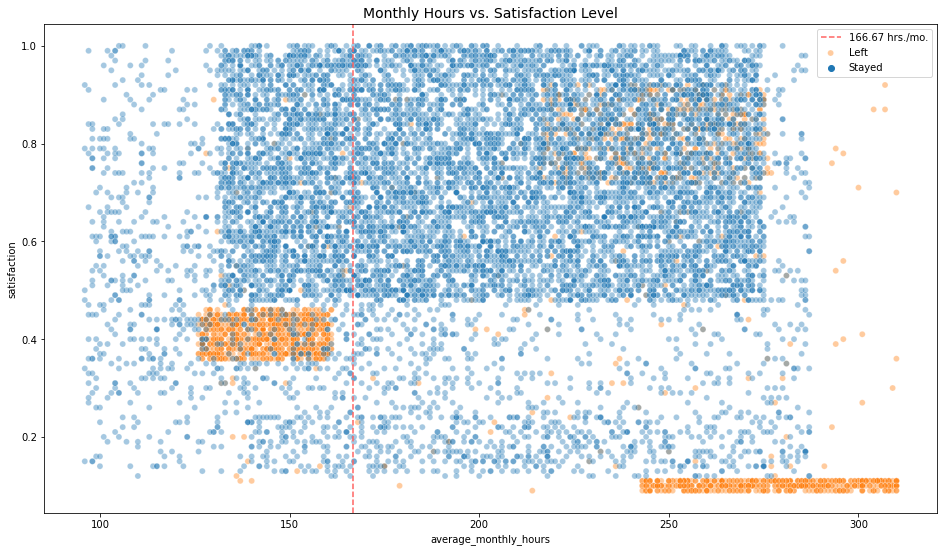

In [15]:
plt.figure(figsize=(16, 9))

# Scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction', hue='left', alpha=0.4)

# Adding a vertical line at the average working hours threshold
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')

# Adding a legend
plt.legend(labels=['166.67 hrs./mo.', 'Left', 'Stayed'])

plt.title('Monthly Hours vs. Satisfaction Level', fontsize='14')

plt.show()

High Monthly Workload and Low Satisfaction: A significant cluster of employees worked approximately 240 to 315 hours per month, which is equivalent to over 75 hours per week for an entire year. These employees had notably low satisfaction levels, approaching zero. This suggests a potential correlation between extreme working hours and low job satisfaction.

Normal Working Hours and Moderate Satisfaction: Another group of departing employees had more typical working hours, but their satisfaction levels were only around 0.4. It's challenging to pinpoint the exact reasons for their departure, but it's possible that they felt compelled to work longer hours due to the prevailing trend among their peers, which might have negatively impacted their job satisfaction.

Moderate Monthly Workload and Varied Satisfaction: There's a group of employees who worked approximately 210 to 280 hours per month, and their satisfaction levels ranged from about 0.7 to 0.9. This suggests that employees in this category had a more balanced workload and experienced varying levels of job satisfaction, possibly related to factors beyond working hours.

It's important to note the unusual shape of the distributions in this scatterplot. The non-standard distribution patterns may raise suspicions of data manipulation or the generation of synthetic data. Further investigation into the data collection and preprocessing methods is advisable to ensure data integrity and reliability for analysis.

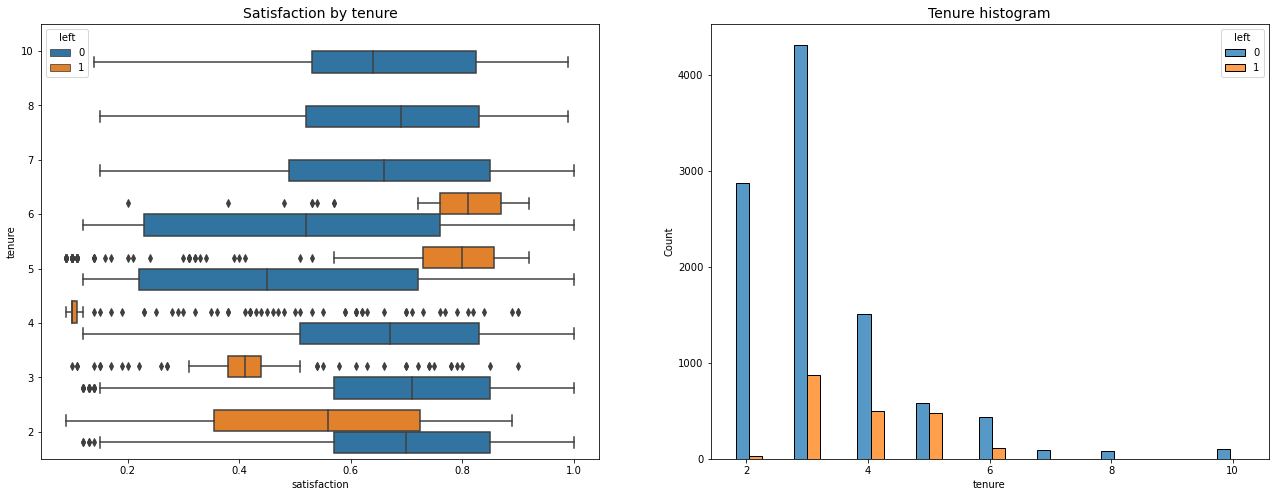

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Boxplot showing distributions of `satisfaction_level` by tenure, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction', y='tenure', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# Histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')

plt.show();

Dissatisfaction and Satisfaction as Departure Drivers: Employees who left can be categorized into two distinct groups:

The first group comprises dissatisfied employees with relatively shorter tenures.
The second group consists of very satisfied employees with medium-length tenures. These individuals might have chosen to leave despite their high satisfaction levels for various reasons.
Concerning Trend at Four Years: Notably, employees with four years of tenure who left the company exhibited an unusually low level of satisfaction. This observation raises questions about whether there were specific company policy changes or other factors that affected employees at the four-year mark, warranting further investigation.

Long-Tenured Employees and Satisfaction: It's evident that the longest-tenured employees did not leave the company. Their satisfaction levels closely aligned with those of newer employees who chose to stay. This suggests that high tenure, coupled with job satisfaction, might contribute to employee retention.

Distribution of Tenure: The histogram on the right side of the plot highlights that there are relatively fewer longer-tenured employees. This observation raises the possibility that these individuals might occupy higher-ranking and higher-paid positions within the organization, contributing to their longer tenure. Further exploration into the demographics and roles of these employees could provide valuable insights.

In summary, this visualization underscores the complex relationship between tenure, satisfaction levels, and employee departure patterns, suggesting potential areas for further investigation and policy consideration.

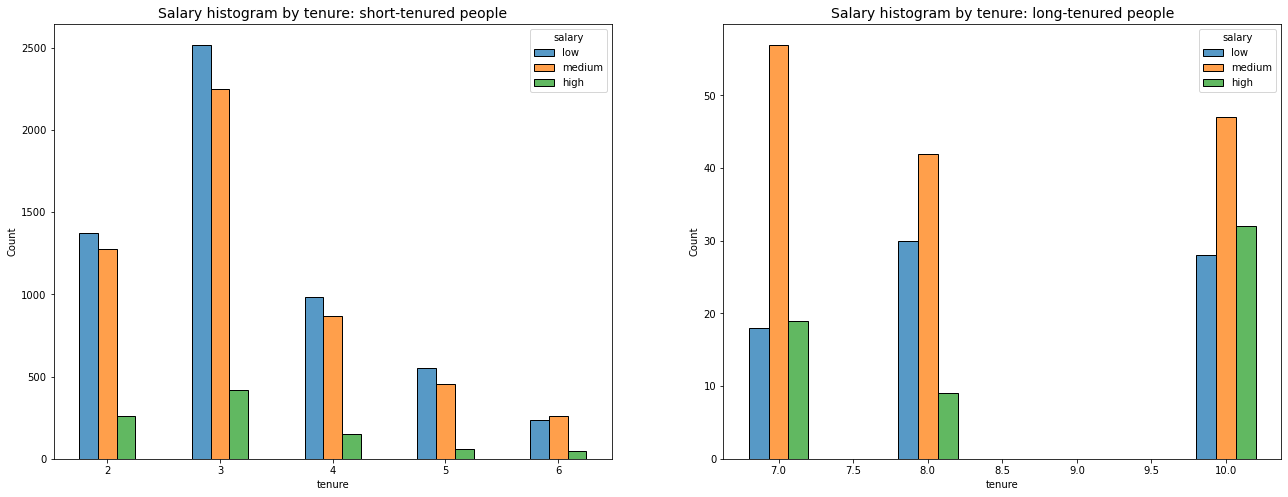

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Defining short-tenured employees
tenure_short = df1[df1['tenure'] < 7]

# Defining long-tenured employees
tenure_long = df1[df1['tenure'] > 6]

# Short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

# Long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

The visualizations above indicate that the group of long-tenured employees did not exhibit a significant overrepresentation of higher-paid individuals.

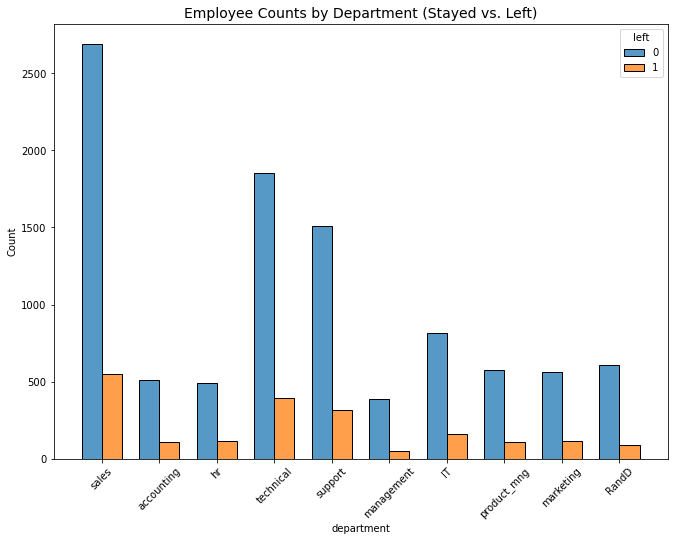

In [18]:
plt.figure(figsize=(11, 8))

# Histogram showing counts of stayed and left employees by department
sns.histplot(data=df1, x='department', hue='left', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.7)
plt.xticks(rotation='45')
plt.title('Employee Counts by Department (Stayed vs. Left)', fontsize=14)

plt.show()

There doesn't appear to be a department where the proportion of employees who left significantly differs from those who chose to stay.

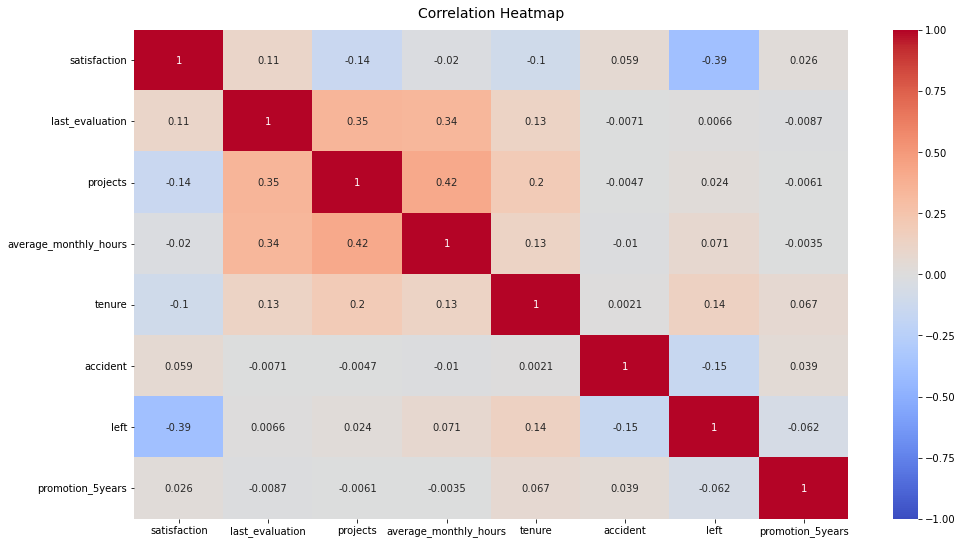

In [19]:
plt.figure(figsize=(16, 9))

# Correlation heatmap with the "coolwarm" color palette
heatmap = sns.heatmap(df0.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 14}, pad=12)

plt.show()

The correlation heatmap validates that there are positive correlations among the number of projects, monthly hours, and evaluation scores. Additionally, it indicates a negative correlation between an employee's decision to leave and their satisfaction level.

### Insights

It seems that employee departures may be linked to management challenges. Leaving is associated with extended working hours, involvement in numerous projects, and generally lower job satisfaction. It can be disheartening to invest substantial time at work without corresponding promotions or favorable evaluation scores. It's evident that a significant portion of employees in this organization may be experiencing burnout. Additionally, the data suggests that employees with more than six years of tenure tend to exhibit higher retention rates.

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





## Step 3. Model Building

### Modeling Approach A: Logistic Regression Model

In [20]:
df_encoded = df1.copy()

# Encoding the `salary` column as an ordinal numeric category
df_encoded["salary"] = (
    df_encoded["salary"].astype("category")
    .cat.set_categories(["low", "medium", "high"])
    .cat.codes
)

# Dummy encoding the `department` column
df_encoded = pd.get_dummies(df_encoded, drop_first=False)

df_encoded.head()

,satisfaction,last_evaluation,projects,average_monthly_hours,tenure,accident,left,promotion_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
z_scores = stats.zscore(df_encoded['tenure'])

# Defining threshold for outlier detection
threshold = 3

# Creating a new DataFrame without outliers
df_logistic = df_encoded[(z_scores >= -threshold) & (z_scores <= threshold)]

y = df_logistic["left"]

X = df_logistic.drop(columns=["left"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

y_pred = clf.predict(X_test)

Data Preparation and Encoding:
The provided dataset was duplicated for further analysis.
The "salary" column was transformed into ordinal numeric categories: "low," "medium," and "high."
The "department" column was converted into a suitable format for analysis by using one-hot encoding.

Outlier Handling:
An assessment for outliers was conducted within the "tenure" column to ensure data quality.
Any values that could potentially skew the analysis were eliminated from the dataset.

Data Splitting:
The dataset was divided into two distinct subsets:
A training set, designed for model training purposes.
A testing set, reserved for evaluating the model's predictive performance.
Care was taken to maintain an equitable distribution of employee attrition ("left") in both sets.

Model Training and Prediction:
A logistic regression model was chosen as the predictive tool for employee attrition analysis.
The model was trained using the training dataset to learn underlying patterns and relationships.
Post-training, the model was employed to make attrition predictions based on the testing dataset.
In summary, the data was meticulously prepared and structured to facilitate analysis. A logistic regression model was trained and assessed for its capacity to forecast employee attrition, with the ultimate goal of deriving valuable insights and data-driven decisions.

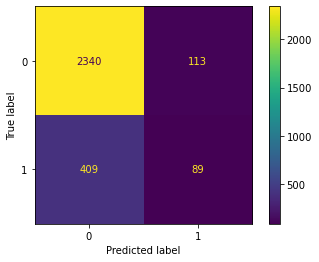

In [22]:
# Computing values for confusion matrix
logistic_cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Confusion matrix
logistic_disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm, 
                                  display_labels=clf.classes_)

logistic_disp.plot(values_format='')

plt.show()

In [23]:
# Classification report for logistic regression model

target_names = ['Predicted would not leave', 'Predicted would leave']

print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.85      0.95      0.90      2453
    Predicted would leave       0.44      0.18      0.25       498

                 accuracy                           0.82      2951
                macro avg       0.65      0.57      0.58      2951
             weighted avg       0.78      0.82      0.79      2951



The classification report presented above indicates that the logistic regression model demonstrated a weighted average precision of 78%, recall of 82%, an f1-score of 79%, and an overall accuracy of 82%. However, it's worth noting that when prioritizing the prediction of employees who leave, these scores noticeably decrease.

### Modeling Approach B: Tree-based Model (Random Forest)

In [24]:
y = df_encoded["left"]

X = df_encoded.drop(columns=["left"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In my project's progression, I proceeded to create a function aimed at extracting all the scores generated through the grid search. This custom function I developed serves to enhance the efficiency of my analysis, allowing me to obtain a comprehensive overview of the results effortlessly.

In [25]:
def make_results(model_name:str, model_object, metric:str):

    # Dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolating the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extracting Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Creating table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [26]:
# Instantiating model

rf = RandomForestClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assigning a dictionary of scoring metrics to capture

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiating GridSearch

rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [27]:
%%time

rf1.fit(X_train, y_train)

CPU times: user 9min 6s, sys: 0 ns, total: 9min 6s
Wall time: 9min 6s


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [28]:
# Best AUC score on CV

rf1.best_score_

0.9820293639756658

In [29]:
# Best params

rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [30]:
rf1_cv_results = make_results('Random Forest cv', rf1, 'auc')

rf1_cv_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest cv,0.945895,0.912254,0.928698,0.97676,0.982029


In [31]:
preds = rf1.best_estimator_.predict(X_test)
    
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)

# Creating a results table

results_table = pd.DataFrame({'model': ['Random Forest test'],
                              'precision': [precision],
                              'recall': [recall],
                              'F1': [f1],
                              'accuracy': [accuracy],
                              'auc': [roc_auc]
                            })

results_table

,model,precision,recall,F1,accuracy,auc
0,Random Forest test,0.960499,0.927711,0.94382,0.981654,0.960055


The Random Forest Classifier demonstrated strong performance on both the cross-validated training data and the test data. On the test data, it achieved slightly higher precision, indicating improved accuracy in classifying positive cases. The recall remains high, suggesting that the model effectively captures true positives. Overall, the model generalizes well to unseen data, maintaining its strong predictive capabilities and accuracy on the test dataset, consistent with its performance during cross-validation.

### Random forest feature importance

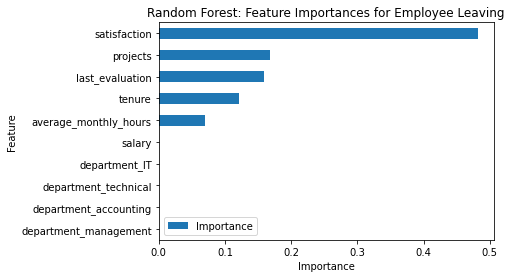

In [32]:
# Feature importances
feat_impt = rf1.best_estimator_.feature_importances_

# Indices of top 10 features
ind = np.argpartition(rf1.best_estimator_.feature_importances_, -10)[-10:]

# Column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

### Modeling Approach C: Tree-based Model (XGBoost)

In [33]:
# 1. Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# 4. Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [34]:
%%time

xgb_cv.fit(X_train, y_train)

CPU times: user 2min 4s, sys: 0 ns, total: 2min 4s
Wall time: 1min 2s


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     predictor=None, random_state=42,
                                     reg_alpha=None, ...),
             iid='deprecate

In [35]:
# Best score

xgb_cv.best_score_

0.9156051526142994

In [36]:
# Best parameters

xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 300}

In [37]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'auc')

xgb_cv_results

,model,precision,recall,F1,accuracy,auc
0,XGB cv,0.965417,0.913594,0.938741,0.980207,0.981293


In [38]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, xgb_val_preds)
precision = precision_score(y_test, xgb_val_preds)
recall = recall_score(y_test, xgb_val_preds)
f1 = f1_score(y_test, xgb_val_preds)
roc_auc = roc_auc_score(y_test, xgb_val_preds)

# Creating a results table

results_table_2 = pd.DataFrame({'model': ['XGB test'],
                              'precision': [precision],
                              'recall': [recall],
                              'F1': [f1],
                              'accuracy': [accuracy],
                              'auc': [roc_auc]
                            })

results_table_2

,model,precision,recall,F1,accuracy,auc
0,XGB test,0.964435,0.925703,0.944672,0.981988,0.959451


These results indicate that the XGBoost model has maintained strong performance when applied to previously unseen test data. It achieves high precision, recall, and accuracy, along with a commendable AUC score, suggesting that the model generalizes well and can effectively predict outcomes on new data.

Comparing these results to the cross-validation results, it seems that the model's performance on the test data is consistent with its performance during cross-validation, which is a positive sign of robust model performance.

In [39]:
all_results = pd.concat([rf1_cv_results, results_table, xgb_cv_results, results_table_2], axis=0)

all_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest cv,0.945895,0.912254,0.928698,0.976760,0.982029
0,Random Forest test,0.960499,0.927711,0.943820,0.981654,0.960055
0,XGB cv,0.965417,0.913594,0.938741,0.980207,0.981293
0,XGB test,0.964435,0.925703,0.944672,0.981988,0.959451


Comparing the two ML models:

Both Random Forest and XGBoost models perform well in terms of precision, recall, and accuracy.
The Random Forest model achieves slightly higher precision and AUC in cross-validation, while the XGBoost model has a slightly higher F1-score.
On the test data, both models maintain strong performance, with the XGBoost model having a slightly higher F1-score.
Overall, both models appear to be effective for the given task, and their performance on the test data is consistent with cross-validation results. The choice between the two models may depend on other factors such as interpretability, computational efficiency, or specific requirements for your project.

### XGBoost feature importance

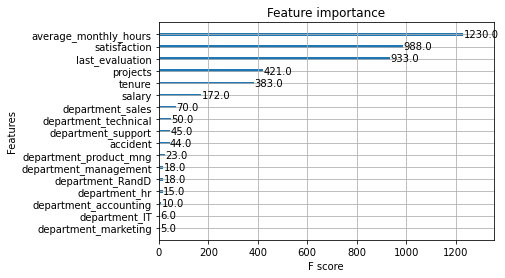

In [40]:
plot_importance(xgb_cv.best_estimator_);

#### Key Factors in Predicting Employee Attrition (XGBoost):

Satisfaction (988.0): Employee satisfaction level is the most critical factor. Higher satisfaction reduces the likelihood of leaving.

Last Evaluation (933.0): Positive performance evaluations are associated with lower attrition.

Average Monthly Hours (1230.0): The number of hours worked per month plays a significant role, with extremes increasing the risk.

Projects (421.0): The number of projects an employee is involved in impacts attrition. Too many or too few projects can lead to leaving.

Tenure (383.0): Longer tenure at the company is linked to lower attrition.

Salary (172.0): Higher salaries are associated with reduced attrition risk.

Department (Sales - 70.0, Technical - 50.0): The department an employee works in matters. "Sales" and "Technical" departments have higher attrition impacts compared to others.

These features are the key drivers behind predicting whether an employee will leave the company. Understanding and addressing these factors can help organizations implement effective retention strategies and reduce attrition rates.

## Step 4. Results and Evaluation

### Summary of model results

#### A, B, C model comparison

The Logistic Regression model achieved the lowest precision, recall, and F1-Score, indicating that it had a harder time identifying employees who would leave.
The Random Forest and XGBoost models performed significantly better in terms of precision, recall, F1-Score, and accuracy. They both excelled in identifying employees at risk of leaving.
Among the three models, the XGBoost model had slightly higher precision, recall, and F1-Score on the test data compared to the Random Forest model.
The Random Forest model had the highest AUC, indicating its strong ability to discriminate between the two classes.
In summary, both the Random Forest and XGBoost models outperformed the Logistic Regression model in predicting employee attrition, with the XGBoost model demonstrating a slight advantage in precision and F1-Score.

### Conclusion, Recommendations, Next Steps

The analysis of the models and their associated feature importances underscores a concerning trend of employee overwork within the company. To mitigate this issue and enhance employee retention, the following recommendations can be proposed to the stakeholders:

1. Implement a project workload cap to ensure employees are not overwhelmed with too many projects simultaneously.

2. Investigate the reasons behind the dissatisfaction of employees with four or more years of tenure. Consider offering promotions or addressing specific concerns to improve their job satisfaction.

3. Evaluate the feasibility of rewarding employees for working longer hours or revisiting policies that require excessive overtime.

4. Ensure that all employees are well-informed about the company's overtime pay policies and that workload expectations and time-off arrangements are clearly communicated.

5. Initiate open discussions at both company-wide and team levels to gain insights into the company's work culture and identify areas that need improvement, both in general and within specific contexts.

6. Reconsider the criteria for high evaluation scores to avoid bias toward employees who work extremely long hours. Implement a more equitable scale that recognizes and rewards contributions and effort proportionately.

By addressing these recommendations, the company can create a healthier work environment, reduce burnout, and improve overall employee satisfaction and retention.